# Providing an interface to the object detector/image classifier via Gradio Library

In [9]:
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import time
from tensorflow import keras
import tensorflow_hub as hub
import keras_utils
import gradio as gr

In [6]:
import json
file = open('classes.json')
classes = json.load(file)

classes = {int(k):v for k,v in classes.items()}
file.close()

In [21]:
args = {'image':"shirt_1.png", 'size': (200, 200), 'min_confidence':0.9999}
WIDTH = 700 
PYR_SCALE = 1.5
WINDOW_STEP = 20*3 
ROI_SIZE = args["size"]
INPUT_SIZE = (224, 224)
IMG_SIZE = 224

In [8]:
model =  tf.keras.models.load_model(
       ('model_ResNet50.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [15]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w) 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

In [16]:
def sliding_window(image, step, win_step):
    for y in range(0, image.shape[0]-win_step[1], step):
        for x in range(0, image.shape[1] - win_step[0], step):
            yield (x, y, image[y:y + win_step[1], x:x + win_step[0]])

## Gradio Function for object detection

In [17]:

def clothes_object_detector(image):
    # image = cv2.imread(input_img)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image
    original_image = imutils.resize(original_image, width = WIDTH)
    (H, W) = original_image.shape[:2]
    pyramid = image_pyramid(original_image, scale=PYR_SCALE, minSize=ROI_SIZE)

    rois = []
    locs = []

    start = time.time()
    counter = 0
    total_images = 0
    for p, image in enumerate(pyramid):

        scale = W / float(image.shape[1])

        sw = 0
        for (x, y, roi_original) in sliding_window(image, WINDOW_STEP, ROI_SIZE):
            sw = sw + 1
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roi_original, INPUT_SIZE)
            roi = tf.keras.preprocessing.image.img_to_array(roi)
            roi = tf.keras.applications.resnet.preprocess_input(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            clone = original_image.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
            total_images = total_images +1


    rois = np.array(rois, dtype="float32")
    my_preds = model.predict(rois)
    preds = []
    for i in range(my_preds.shape[0]):
        preds.append((classes[np.argmax(my_preds[i], axis=-1)], max(my_preds[i])))
            

    labels = {}
    for (i, p) in enumerate(preds):
        (label, prob) = p
        if prob >= args["min_confidence"]:
            box = locs[i]

            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
            allclone = original_image.copy()
    for label in labels.keys():
        clone = original_image.copy()
        for (box, prob) in labels[label]:
            (startX, startY, endX, endY) = box
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

        clone = original_image.copy()

        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)

        for (startX, startY, endX, endY) in boxes:
            cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
    return allclone

demo = gr.Interface(clothes_object_detector, gr.Image(), "image")
demo.launch()

Running on local URL:  http://127.0.0.1:7865/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x1f50227a0a0>, 'http://127.0.0.1:7865/', None)

## Gradio Function for Cloth Image Classification

Running on local URL:  http://127.0.0.1:7869/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x1f5026cee80>, 'http://127.0.0.1:7869/', None)

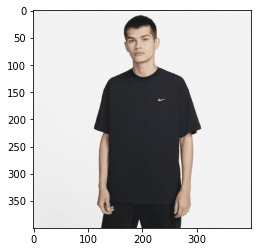

In [22]:
def clothes_image_classifier(image):
    img_show = image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = np.reshape(image, [1, IMG_SIZE, IMG_SIZE, 3]) / 255.0

    img_class = np.argmax(model.predict(image), axis=-1)
    prediction = img_class[0]
    plt.imshow(img_show/255.)
    clothe_type, for_kids = classes[prediction].split(" ")
    if for_kids == 'False':
        prediction = "{} worn by adults".format(clothe_type)
    else:
        prediction = "{} worn by kids".format(clothe_type)

    return prediction
demo2 = gr.Interface(clothes_image_classifier, gr.Image(), "text")
demo2.launch()